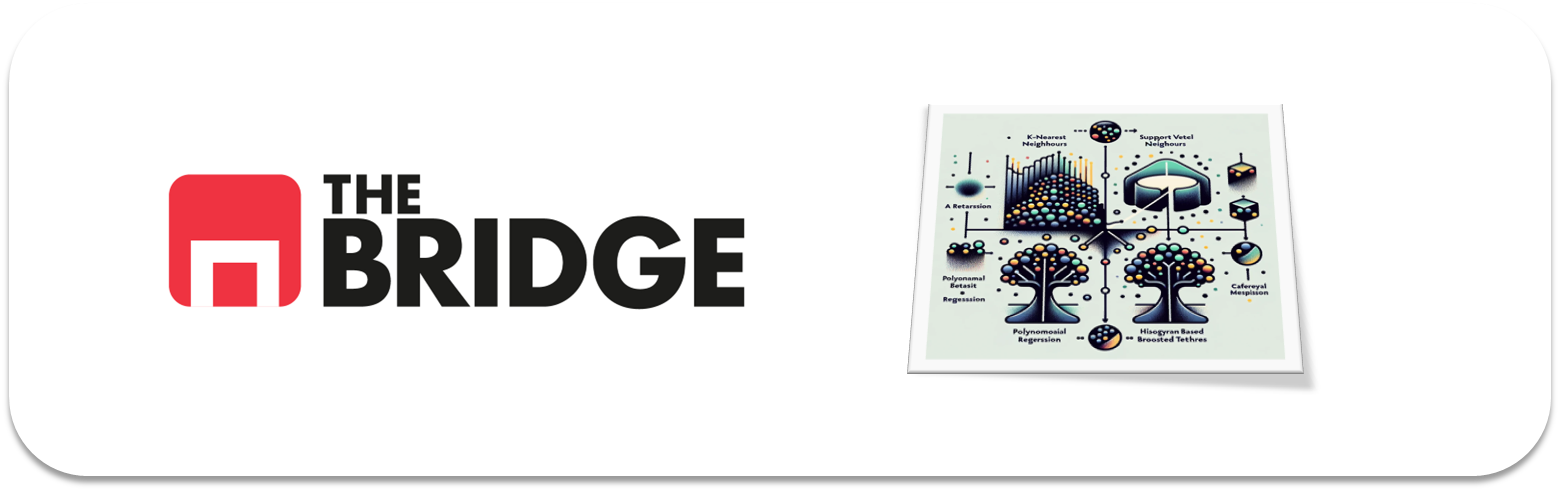

## PRACTICA OBLIGATORIA: **Otros Modelos Supervisados**

* La práctica obligatoria de esta unidad consiste en resolver un modelado de clasificación, incluyendo KNN entre los posibles modelos, y aplicando balanceado. Para ello utilizaremos un dataset que ya hemos empleado en los workout. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [ ]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
pd.options.mode.copy_on_write = True

### #1. El problema y los datos

Vamos a volver al dataset con el que vimos la clasificación binaria con regresión logística, "Give me some credit", y nuestro objetivo es crear un modelo que nos permita predicir si una persona va a encontrarse en dificultades financieras en los dos próximos años. El dataset de partida lo puedes en contrar en el directorio data que acompaña al ejercicio. 

### #1.1
Cárgalo y, apoyándote en las herramientas y fuentes que consideres necesarias, haz una descripción textual de sus variables. Luego con ayuda de los datos, haz una clasificación inicial de sus variables en categóricas y numéricas.

In [2]:
df = pd.read_csv("./data/credit_npo.csv")

In [3]:
df.sample(5)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
9103,0,0.010603,50,0,0.196611,9500.0,22,0,1,0,4.0
10992,0,0.400673,35,1,0.318018,5549.0,6,0,1,0,1.0
894,0,0.789917,37,4,0.306216,4166.0,8,1,0,0,0.0
5383,0,0.133589,49,0,0.167391,9199.0,8,0,1,0,0.0
3719,0,0.300686,36,0,0.052490,3333.0,5,0,0,0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [5]:
df.isna().sum()[df.isna().sum() > 0]

MonthlyIncome         721
NumberOfDependents    177
dtype: int64

Parece que MonthlyIncome y NumberOfDependents necesitan tratamiento de nulos.

# Interpretación de variables

#### Variable objetivo
**SeriousDlqin2yrs**  
   Morosidad grave en los últimos 2 años
   - **1**: impago serio / default
   - **0**: no tuvo impago

#### Uso del crédito
**RevolvingUtilizationOfUnsecuredLines**  
   - Porcentaje de utilización de líneas de crédito sin garantía  
   - Valores altos indican posible sobreendeudamiento.

#### Datos demográficos
**age**  
   - Edad del cliente en años.

**NumberOfDependents**  
    - Número de personas dependientes económicamente del cliente.

#### Situación financiera
**DebtRatio**  
   - Ratio deuda / ingresos.
   - Mide qué parte del ingreso mensual está comprometida en pagos de deuda.

**MonthlyIncome**  
   - Ingreso mensual declarado.

#### Exposición al crédito
**NumberOfOpenCreditLinesAndLoans**
   - Número total de líneas de crédito abiertas (tarjetas, préstamos, etc.).

**NumberRealEstateLoansOrLines**  
   - Número de préstamos o líneas relacionadas con bienes inmuebles (hipotecas).

#### Historial de atrasos
 **NumberOfTime30-59DaysPastDueNotWorse**  
   - Veces que el cliente se retrasó entre 30 y 59 días.

**NumberOfTime60-89DaysPastDueNotWorse**  
    - Veces con retrasos entre 60 y 89 días.

**NumberOfTimes90DaysLate**  
   - Veces con retrasos mayores a 90 días.


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,12537.0,0.068916,0.253321,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,12537.0,0.330359,0.368148,0.0,0.030651,0.163490,0.582219,6.0
age,12537.0,52.079445,15.077498,21.0,41.000000,51.000000,62.000000,101.0
NumberOfTime30-59DaysPastDueNotWorse,12537.0,0.409588,4.055787,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,12537.0,1.902253,9.122216,0.0,0.142268,0.302025,0.506725,99.0
MonthlyIncome,11816.0,6864.815420,11855.905437,0.0,3498.750000,5416.000000,8300.000000,702500.0
NumberOfOpenCreditLinesAndLoans,12537.0,8.482332,5.165422,0.0,5.000000,8.000000,11.000000,49.0
NumberOfTimes90DaysLate,12537.0,0.259312,4.035658,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,12537.0,0.999202,1.134325,0.0,0.000000,1.000000,2.000000,19.0
NumberOfTime60-89DaysPastDueNotWorse,12537.0,0.228364,4.018873,0.0,0.000000,0.000000,0.000000,98.0


### #1.2
¿Qué tipo de problema estamos tratando? ¿Cuál es la variable target?

Es un problema de clasificación binaria y la variable target es 'SerieousDlquin2yrs'.

### #1.3
Pinta la distribución de frecuencias del target y coméntala

In [7]:
target = "SeriousDlqin2yrs"

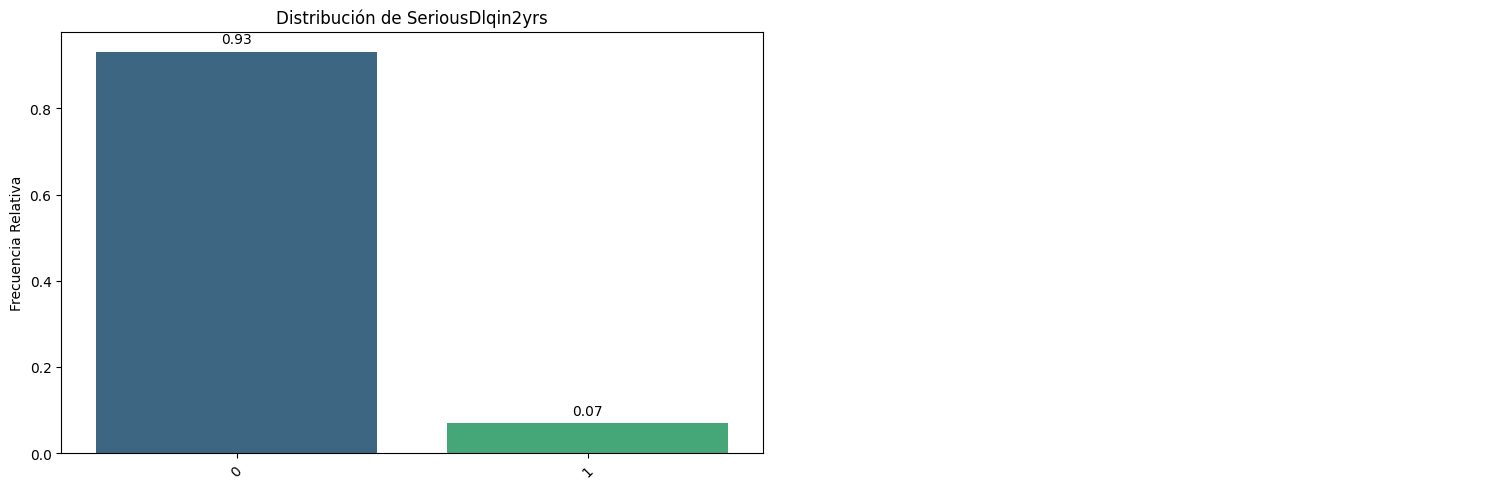

In [8]:
bt.pinta_distribucion_categoricas(df,[target], mostrar_valores= True, relativa= True)

El taret está muy desequilibrado o muy desbalanceado. 

### #2 Modelado

Realiza un proceso completo de modelado hasta dar con el mejor modelo de los que hayas escogido (emplea al menos 3, y uno tiene que ser KNN). Aplica las técnicas que creas necesarias para obtener el mejor resultado (suponiendo que este después de hablar con el negocio es el recall medio, para tener un compromiso entre las dos clases). Para comparar modelos emplea validación cruzada antes de optimización y luego ajusta los hiperparámetros del mejor modelo. Evalúa este y haz un pequeño análisis de errores.

In [9]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42, stratify = df['SeriousDlqin2yrs'])

"NumberOfDependents" es numérica discreta, así que priorizaremos la moda.

In [10]:
moda_ndp = train_set["NumberOfDependents"].mode()

In [11]:
train_set["NumberOfDependents"] = train_set["NumberOfDependents"].fillna(moda_ndp[0])
test_set["NumberOfDependents"] = test_set["NumberOfDependents"].fillna(moda_ndp[0])

In [12]:
train_set["MonthlyIncome"] = train_set["MonthlyIncome"].fillna(train_set["MonthlyIncome"].median())
test_set["MonthlyIncome"] = test_set["MonthlyIncome"].fillna(train_set["MonthlyIncome"].median())

### Mini-EDA

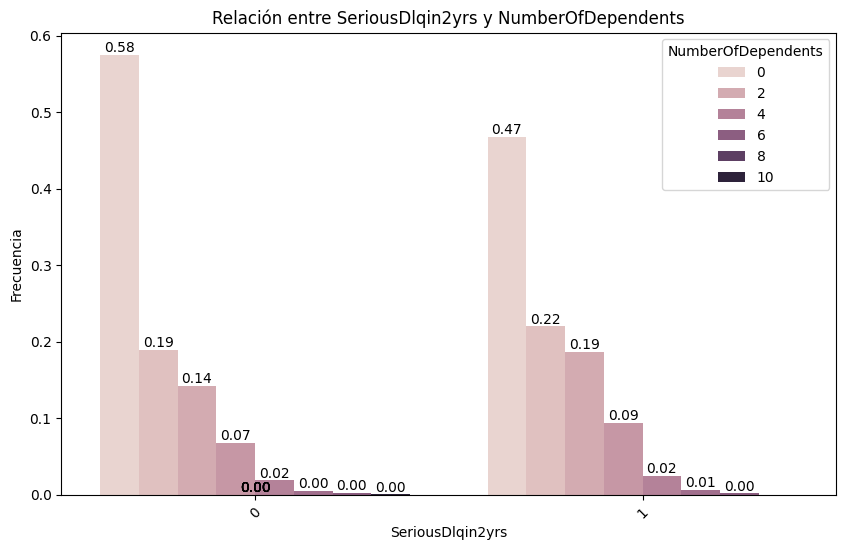

In [13]:
bt.plot_categorical_relationship_fin(train_set, target, "NumberOfDependents", show_values= True, relative_freq= True)

Las distribuciones son similares, así que parece que no es una buena candidata.

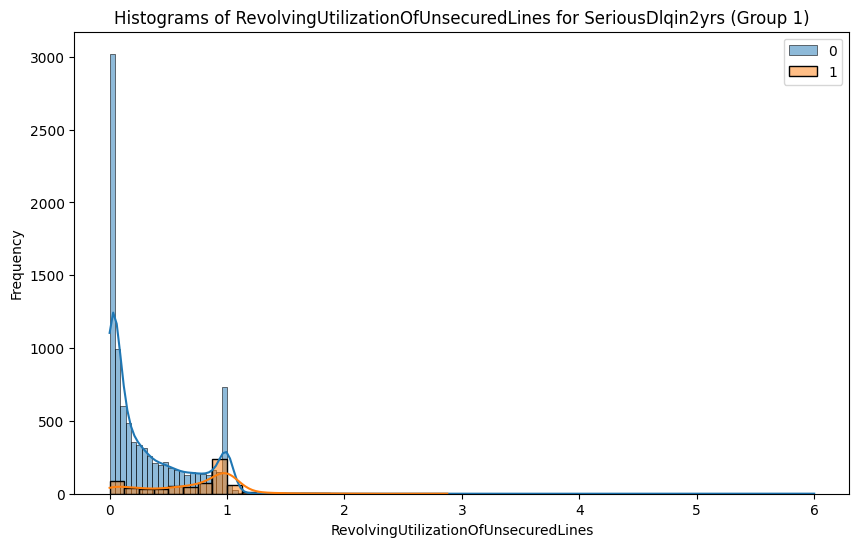

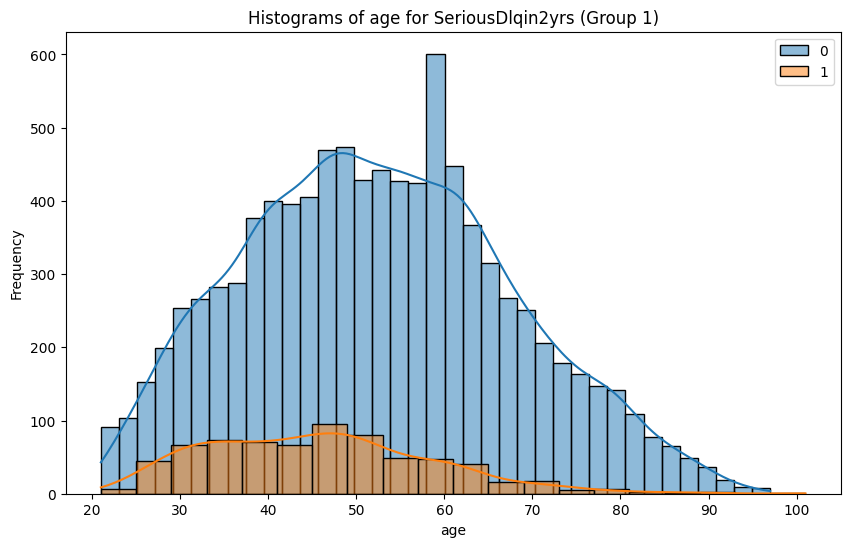

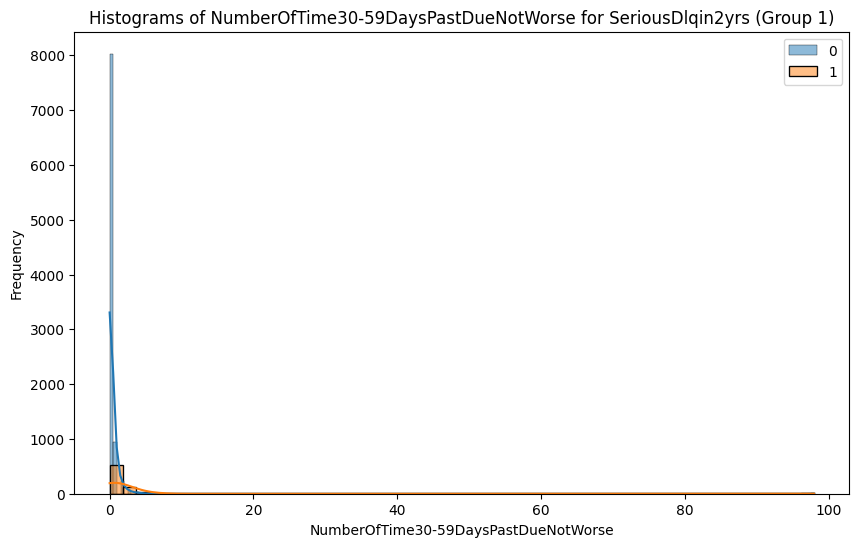

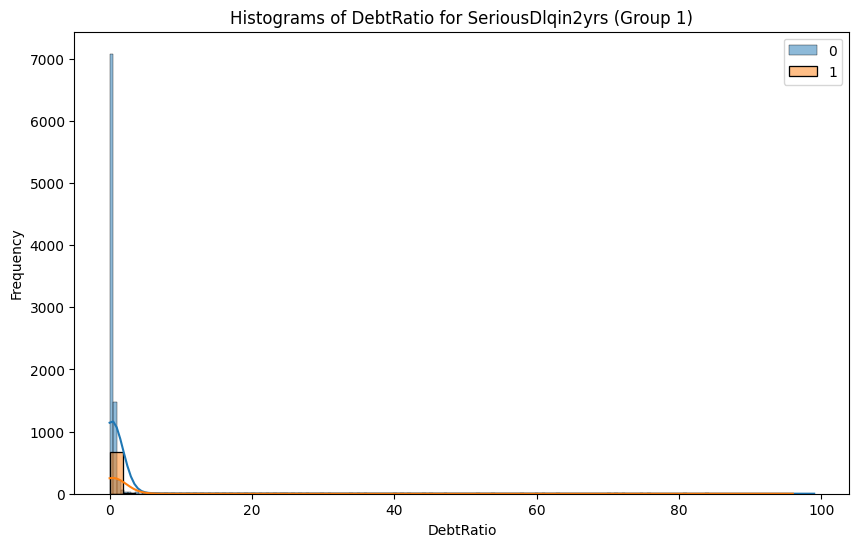

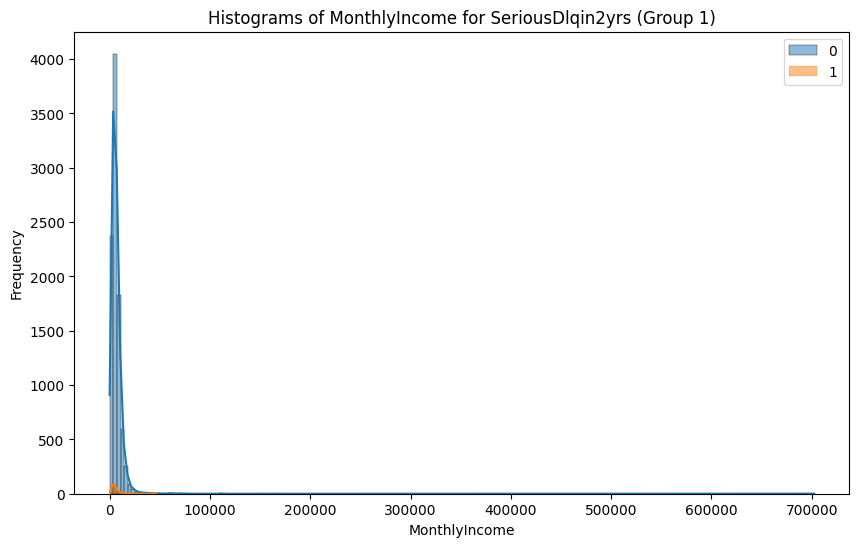

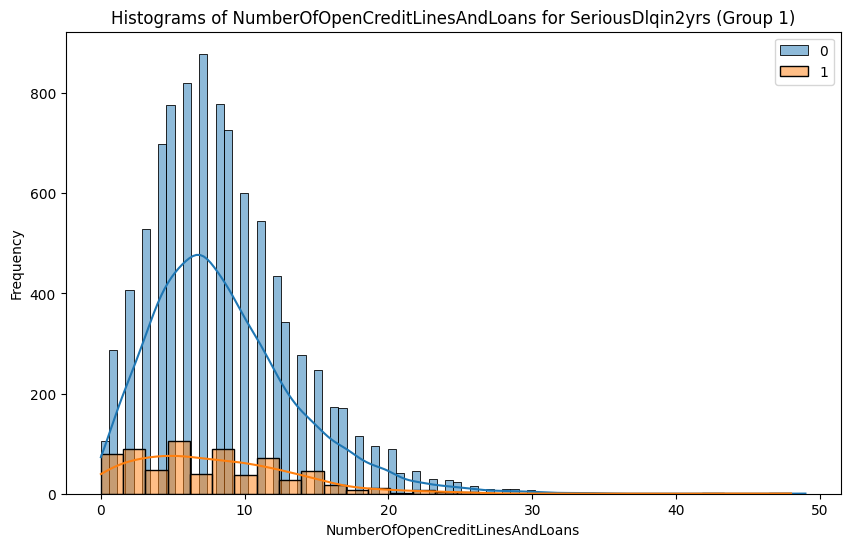

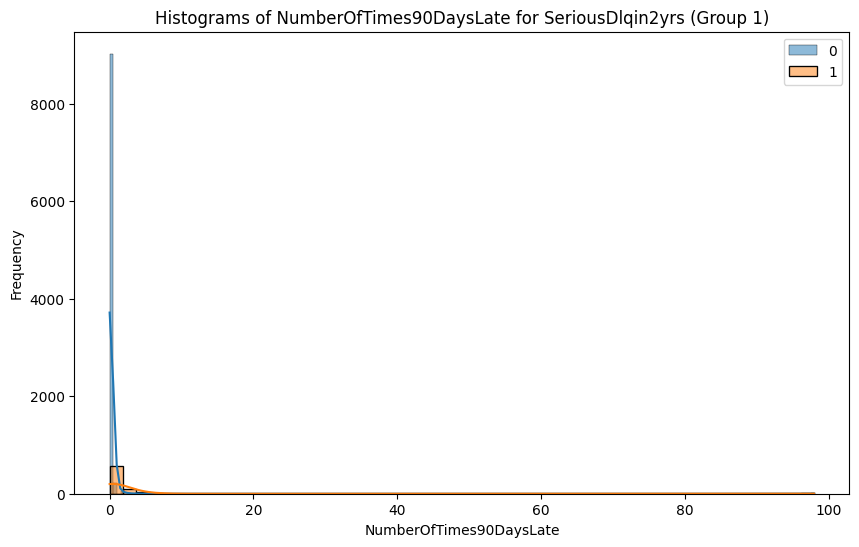

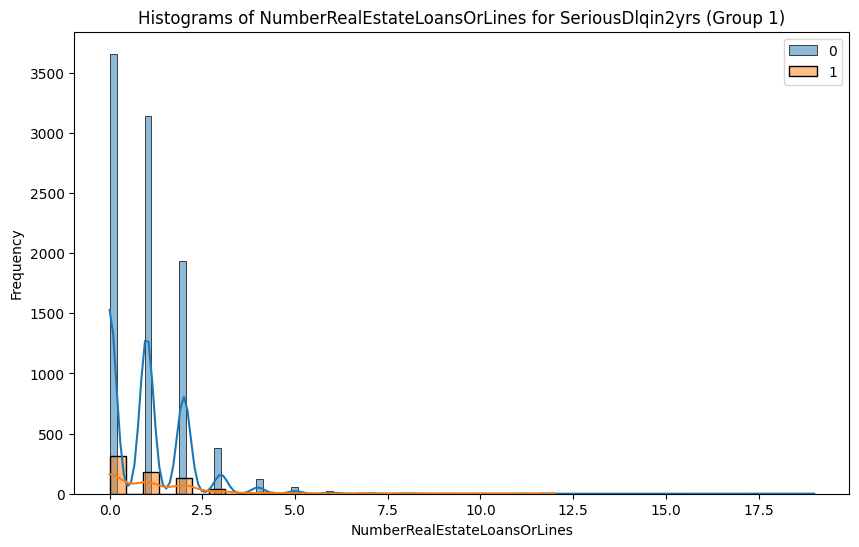

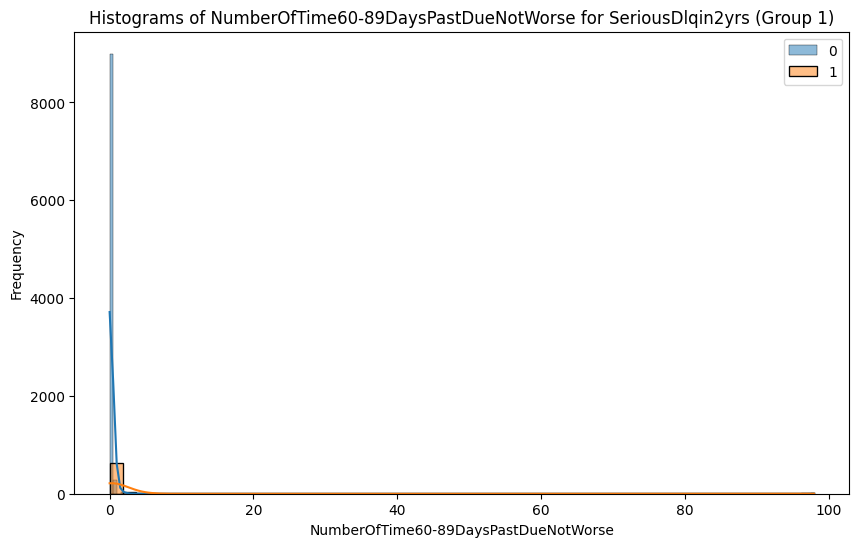

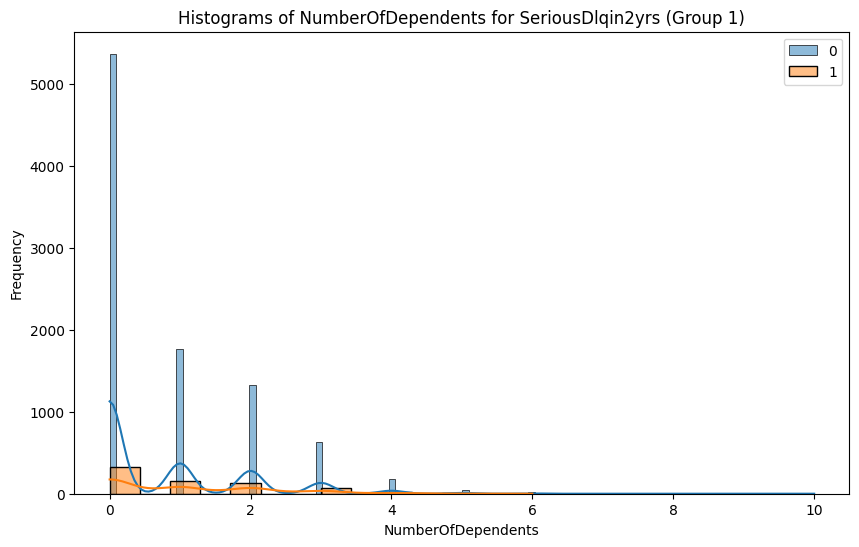

In [14]:
features = [col for col in train_set.columns if col != target]

for col in features:
    bt.plot_grouped_histograms(train_set, cat_col= target, num_col= col, group_size= 2)

Difícil de ver, aunque "NumberOfTime" es la que tiene más interacciones, así que nos las quedaremos.

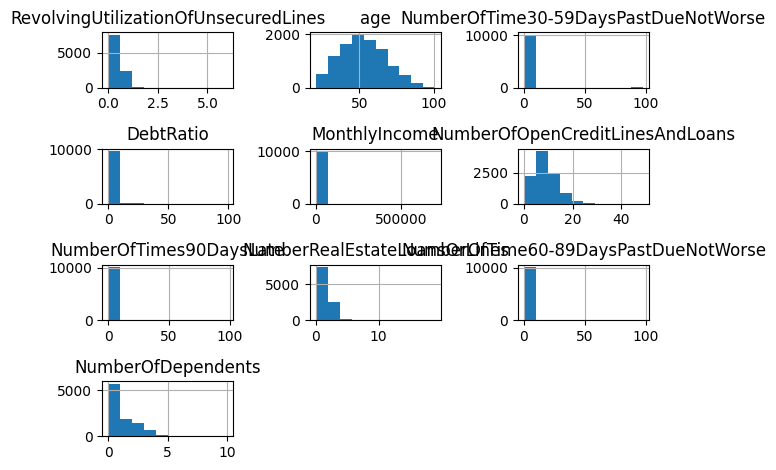

In [15]:
train_set[features].hist()
plt.tight_layout()

Todas excepto age necesitan normalización.

In [16]:
train_set_scaled = train_set.copy()
test_set_scaled = test_set.copy()

In [17]:
for col in features:
    if col != "age":
        train_set_scaled[col] = np.log(train_set_scaled[col]+1) 
        test_set_scaled[col] = np.log(test_set_scaled[col]+1)

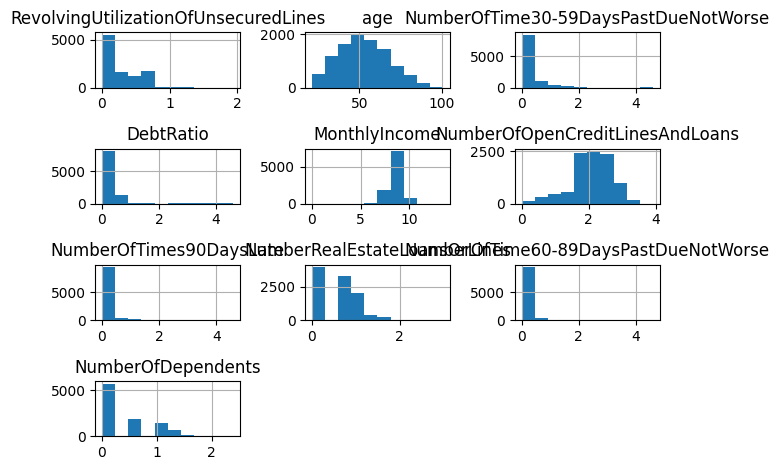

In [18]:
train_set_scaled[features].hist()
plt.tight_layout()

In [19]:
scaler = StandardScaler()

train_set_scaled[features] = scaler.fit_transform(train_set_scaled[features])
test_set_scaled[features] = scaler.transform(test_set_scaled[features])

In [20]:
X_train = train_set[features]
X_train_scaled = train_set_scaled[features]
y_train = train_set[target]

X_test = test_set[features]
X_test_scaled = test_set_scaled[features]
y_test = test_set[target]

In [21]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10029 entries, 8818 to 10443
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   RevolvingUtilizationOfUnsecuredLines  10029 non-null  float64
 1   age                                   10029 non-null  float64
 2   NumberOfTime30-59DaysPastDueNotWorse  10029 non-null  float64
 3   DebtRatio                             10029 non-null  float64
 4   MonthlyIncome                         10029 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans       10029 non-null  float64
 6   NumberOfTimes90DaysLate               10029 non-null  float64
 7   NumberRealEstateLoansOrLines          10029 non-null  float64
 8   NumberOfTime60-89DaysPastDueNotWorse  10029 non-null  float64
 9   NumberOfDependents                    10029 non-null  float64
dtypes: float64(10)
memory usage: 861.9 KB


### Baseline

In [22]:
knn_clf = KNeighborsClassifier(n_neighbors= 5) 

knn_clf.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [23]:
print(classification_report(y_train, knn_clf.predict(X_train_scaled)))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      9338
           1       0.76      0.27      0.40       691

    accuracy                           0.94     10029
   macro avg       0.85      0.63      0.69     10029
weighted avg       0.94      0.94      0.93     10029



No es para nada un buen clasificador.

In [48]:
resultados = []

modelos = {
    "Logistic": LogisticRegression(max_iter = 10000),  
    "RandomForest": RandomForestClassifier(max_depth = 5, random_state= 42),
    "XGB": XGBClassifier(max_depth = 5, random_state= 42),
    "LHBM": LGBMClassifier(max_depth= 5, random_state= 42, verbose=-100, n_jobs= -1),
    "KNN": knn_clf
    }
    
for model_nombre, modelo in modelos.items():
    print(f"Para {model_nombre}:", end = " ")
    if model_nombre in ["Logistic", "KNN"]:
        resultado = np.mean(cross_val_score(modelo, X_train, y_train, cv=5, scoring="balanced_accuracy"))
    else:
        resultado = np.mean(cross_val_score(modelo, X_train_scaled, y_train, cv=5, scoring="balanced_accuracy"))
    print(resultado)
    resultados.append({
        "Modelo": model_nombre,
        "balanced_accuracy": resultado
    })

df_resultados = pd.DataFrame(resultados).sort_values(by="balanced_accuracy", ascending=False).reset_index(drop=True)

ganador = df_resultados.iloc[0]
print(f"\n🏆 GANADOR: {ganador['Modelo']}:(Recall: {ganador['balanced_accuracy']})")

Para Logistic: 0.5315143764499788
Para RandomForest: 0.5530236197667666
Para XGB: 0.5981654200139266
Para LHBM: 0.5947578990880842
Para KNN: 0.5000268560788795

🏆 GANADOR: XGB:(Recall: 0.5981654200139266)


Nos quedaremos con XGB, aunque debemos tener en cuenta el desbalanceo inicial.

#### Oversampling

In [35]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

X_train_smote_scaled, y_train_smote_scaled = smote.fit_resample(X_train_scaled, y_train) # Esto es un apaño: Ojo porque ahora no estamos entrenando contra los mismos trains exactamente para eso tendríamos que haber reescalado el X_train, usando los mismos valores originales.


In [36]:
print(len(y_train))
print(len(y_train_smote))

10029
18676


In [37]:
resultados = []

modelos = {
    "Logistic": LogisticRegression(max_iter = 10000),  
    "RandomForest": RandomForestClassifier(max_depth = 5, random_state= 42),
    "XGB": XGBClassifier(max_depth = 5, random_state= 42),
    "LHBM": LGBMClassifier(max_depth= 5, random_state= 42, verbose=-100, n_jobs= -1),
    "KNN": knn_clf
    }
    
for model_nombre, modelo in modelos.items():
    print(f"Para {model_nombre}:", end = " ")
    if model_nombre in ["Logistic", "KNN"]:
        resultado = np.mean(cross_val_score(modelo, X_train_smote, y_train_smote, cv=5, scoring="balanced_accuracy"))
    else:
        resultado = np.mean(cross_val_score(modelo, X_train_smote_scaled, y_train_smote_scaled, cv=5, scoring="balanced_accuracy"))
    print(resultado)
    resultados.append({
        "Modelo": model_nombre,
        "balanced_accuracy": resultado
    })

df_resultados = pd.DataFrame(resultados).sort_values(by="balanced_accuracy", ascending=False).reset_index(drop=True)

ganador = df_resultados.iloc[0]
print(f"\n🏆 GANADOR: {ganador['Modelo']}:(Recall: {ganador['balanced_accuracy']})")

Para Logistic: 0.7577111880067302
Para RandomForest: 0.7998509271248977
Para XGB: 0.943086648644495
Para LHBM: 0.9305559537968708
Para KNN: 0.8051505696252621

🏆 GANADOR: XGB:(Recall: 0.943086648644495)


Parece que le ha sentado bien el cambio. Vamos a contrastar con el Undersampling

In [38]:
# Separar las clases mayoritaria y minoritaria
clase_mayoritaria = X_train[y_train == 0]
clase_minoritaria = X_train[y_train == 1]

clase_mayoritaria_scaled = X_train_scaled[y_train == 0]
clase_minoritaria_scaled = X_train_scaled[y_train == 1]


In [39]:
# Bajomuestrear la clase mayoritaria para no escalado
clase_mayoritaria_bajomuestreo = resample(clase_mayoritaria,
                                          replace=False,
                                          n_samples=len(clase_minoritaria),  # igual al número de la clase minoritaria
                                          random_state=42)

# Combinar la clase minoritaria con la clase mayoritaria bajomuestreada (importante es que resample mantiene los índices para que lo que viene a continuación tenga sentido)
X_train_bajomuestreo = pd.concat([clase_mayoritaria_bajomuestreo, clase_minoritaria])
y_train_bajomuestreo = pd.concat([y_train.loc[clase_mayoritaria_bajomuestreo.index], 
                                  y_train.loc[clase_minoritaria.index]])


In [40]:
# Bajomuestrear la clase mayoritaria para escalado
clase_mayoritaria_bajomuestreo_scl = resample(clase_mayoritaria_scaled,
                                          replace=False,
                                          n_samples=len(clase_minoritaria_scaled),  # igual al número de la clase minoritaria
                                          random_state=42)

# Combinar la clase minoritaria con la clase mayoritaria bajomuestreada (importante es que resample mantiene los índices para que lo que viene a continuación tenga sentido)
X_train_bajomuestreo_scl = pd.concat([clase_mayoritaria_bajomuestreo_scl, clase_minoritaria_scaled])
y_train_bajomuestreo_scl = pd.concat([y_train.loc[clase_mayoritaria_bajomuestreo_scl.index], 
                                  y_train.loc[clase_minoritaria_scaled.index]])


In [47]:
resultados = []

modelos = {
    "Logistic": LogisticRegression(max_iter = 10000),  
    "RandomForest": RandomForestClassifier(max_depth = 5, random_state= 42),
    "XGB": XGBClassifier(max_depth = 5, random_state= 42),
    "LHBM": LGBMClassifier(max_depth= 5, random_state= 42, verbose=-100, n_jobs= -1),
    "KNN": knn_clf
    }
    
for model_nombre, modelo in modelos.items():
    print(f"Para {model_nombre}:", end = " ")
    if model_nombre in ["Logistic", "KNN"]:
        resultado = np.mean(cross_val_score(modelo, X_train_bajomuestreo, y_train_bajomuestreo, cv=5, scoring="balanced_accuracy"))
    else:
        resultado = np.mean(cross_val_score(modelo, X_train_bajomuestreo_scl, y_train_bajomuestreo_scl, cv=5, scoring="balanced_accuracy"))
    print(resultado)
    resultados.append({
        "Modelo": model_nombre,
        "balanced_accuracy": resultado
    })

df_resultados = pd.DataFrame(resultados).sort_values(by="balanced_accuracy", ascending=False).reset_index(drop=True)

ganador = df_resultados.iloc[0]
print(f"\n🏆 GANADOR: {ganador['Modelo']}:(Recall: {ganador['balanced_accuracy']})")

Para Logistic: 0.7518246272547179
Para RandomForest: 0.7663225940986342
Para XGB: 0.7366541549369201
Para LHBM: 0.7446147429882181
Para KNN: 0.5542122823480347

🏆 GANADOR: RandomForest:(Recall: 0.7663225940986342)


Mismo ganador con métricas muy inferiores.

### Class weights

In [45]:
resultados = []

modelos = {
    "Logistic": LogisticRegression(max_iter = 10000, class_weight= "balanced"),  
    "RandomForest": RandomForestClassifier(max_depth = 5, random_state= 42, class_weight= "balanced"),
    "XGB": XGBClassifier(max_depth = 5, random_state= 42, scale_pos_weight = len(train_set[train_set[target] == 0])/len(train_set[target] == 1)),
    "LGBM": LGBMClassifier(max_depth= 5, random_state= 42, verbose=-100, n_jobs= -1, class_weight= "balanced"),
    "KNN": KNeighborsClassifier(n_neighbors= 5, weights= "distance") 
    }
    
for model_nombre, modelo in modelos.items():
    print(f"Para {model_nombre}:", end = " ")
    if model_nombre in ["Logistic", "KNN"]:
        resultado = np.mean(cross_val_score(modelo, X_train, y_train, cv=5, scoring="balanced_accuracy"))
    else:
        resultado = np.mean(cross_val_score(modelo, X_train_scaled, y_train, cv=5, scoring="balanced_accuracy"))
    print(resultado)
    resultados.append({
        "Modelo": model_nombre,
        "balanced_accuracy": resultado
    })

df_resultados = pd.DataFrame(resultados).sort_values(by="balanced_accuracy", ascending=False).reset_index(drop=True)

ganador = df_resultados.iloc[0]
print(f"\n🏆 GANADOR: {ganador['Modelo']}:(Recall: {ganador['balanced_accuracy']})")

Para Logistic: 0.7556384620379871
Para RandomForest: 0.7640960909199432
Para XGB: 0.5875349579126563
Para LGBM: 0.7436125722662453
Para KNN: 0.5014158216388754

🏆 GANADOR: RandomForest:(Recall: 0.7640960909199432)


Los mejores modelos son XGB con oversampling y RandomForest con classweights. Probaremos a optimizar estos 2 y también el modelos sin mejorías, ya que tiene datos "más naturales".

In [49]:
### XGB

param_grid = {
    "n_estimators": [100,200],
    "learning_rate": [0.1,0.5,1],
    "max_depth": [5,10,15],
    "min_data_in_leaf": [1,10,20,100],
    "class_weight": ["balanced",None]
}

xgb_clf = XGBClassifier(verbose = -1)

xgb_grid = GridSearchCV(xgb_clf,
                        param_grid= param_grid,
                        cv = 5,
                        scoring= "balanced_accuracy",
                        n_jobs=-1)

xgb_grid.fit(X_train, y_train)

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2896: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:37:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "class_weight", "min_data_in_leaf", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [5, 10, 15],
                         'min_data_in_leaf': [1, 10, 20, 100],
                         'n_estimators': [100, 200]},
             scoring='balanced_accuracy')

In [50]:
xgb_grid.best_params_

{'class_weight': 'balanced',
 'learning_rate': 1,
 'max_depth': 15,
 'min_data_in_leaf': 1,
 'n_estimators': 200}

In [51]:
xgb_grid.best_score_

np.float64(0.6092167409791748)

In [52]:
print(classification_report(y_test, xgb_grid.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      2335
           1       0.34      0.21      0.26       173

    accuracy                           0.92      2508
   macro avg       0.64      0.59      0.61      2508
weighted avg       0.90      0.92      0.91      2508



In [53]:
### XGB oversampling

param_grid = {
    "n_estimators": [100,200],
    "learning_rate": [0.1,0.5,1],
    "max_depth": [5,10,15],
    "min_data_in_leaf": [1,10,20,100],
    "class_weight": ["balanced",None]
}

xgb_clf = XGBClassifier(verbose = -1)

xgb_grid = GridSearchCV(xgb_clf,
                        param_grid= param_grid,
                        cv = 5,
                        scoring= "balanced_accuracy",
                        n_jobs=-1)

xgb_grid.fit(X_train_smote,y_train_smote)

c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [12:43:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "class_weight", "min_data_in_leaf", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'learning_rate': [0.1, 0.5, 1],
                         'max_depth': [5, 10, 15],
                         'min_data_in_leaf': [1, 10, 20, 100],
                         'n_estimators': [100, 200]},
             scoring='balanced_accuracy')

In [55]:
print(classification_report(y_test, xgb_grid.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2335
           1       0.31      0.34      0.32       173

    accuracy                           0.90      2508
   macro avg       0.63      0.64      0.64      2508
weighted avg       0.91      0.90      0.90      2508



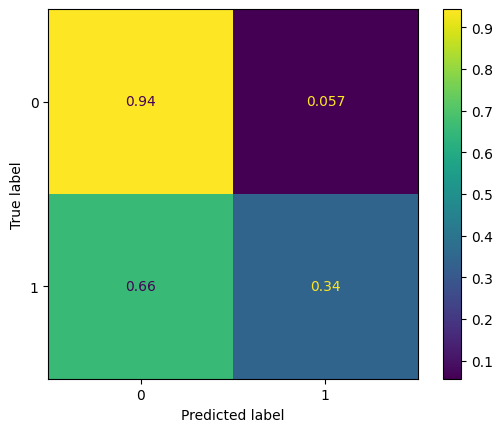

In [57]:
ConfusionMatrixDisplay.from_predictions(y_test, xgb_grid.best_estimator_.predict(X_test), normalize = "true")
plt.show()